In [224]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, multilabel_confusion_matrix
from sklearn.model_selection import train_test_split
import torch
from torch.nn import CrossEntropyLoss, BCEWithLogitsLoss
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, BertTokenizer, BertModel, BertForSequenceClassification
from zipfile import ZipFile

## Set Torch Backend Accelerator

In [225]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


## Global Variables

In [226]:
TRAIN = True
TEST = False

DATASET_PATH = '/kaggle/input/jigsaw-toxic-comment-classification-challenge'
MODEL_SAVE = '/kaggle/working/saved-model'
MODEL_LOAD = '/kaggle/input/saved-toxic-model'

## Unzip Dataset

In [227]:
for file_name in os.listdir(DATASET_PATH):
    zip_file_path = os.path.join(DATASET_PATH, file_name)
    output_dir = '/kaggle/working/'
    
    with ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(output_dir)

## Dataset Information and Distribution

In [228]:
train = pd.read_csv("/kaggle/working/train.csv")

In [229]:
class_labels = [col for col in train.columns if train[col].dtypes == 'int64']
print(f'Class Labels: {class_labels}')

Class Labels: ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']


In [230]:
print('Train Dataset Labels:\n')
print(train[class_labels].sum())

Train Dataset Labels:

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64


In [231]:
test = pd.read_csv("/kaggle/working/test.csv")
test_labels = pd.read_csv("/kaggle/working/test_labels.csv")

#  test dataset has toxic labels of -1 so they must be removed (because this competition is over, -1 labels indicate they weren't used in the final competition)
test_labels = test_labels[test_labels['toxic'] > -1]
test = test[test['id'].isin(test_labels['id'])]
test = pd.concat([test, test_labels[class_labels]], axis = 1)

print('Test Dataset Labels:\n')
test[class_labels].sum()

Test Dataset Labels:



toxic            6090
severe_toxic      367
obscene          3691
threat            211
insult           3427
identity_hate     712
dtype: int64

## Add New Class Label

In [232]:
# train['good'] = [0 if any(i) else 1 for i in train[class_labels].values]
# test['good'] = [0 if any(i) else 1 for i in test[class_labels].values]
# class_labels = [col for col in train.columns if train[col].dtypes == 'int64']
# print(f'NEW Class Labels: {class_labels}')

NEW Class Labels: ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'good']


## Add Weights

In [233]:
# Add Train Weights
total_train_labeled = sum([1 if any(i) else 0 for i in train[class_labels].values])
total_train_notlabeled = len(train) - total_train_labeled
train['weight'] = [(total_train_notlabeled/total_train_labeled if any(i) else 1) for i in train[class_labels].values]
# train['weight'] = [1]*len(train)

In [234]:
# Add Test Weights
total_test_labeled = sum([1 if any(i) else 0 for i in test[class_labels].values])
total_test_notlabeled = len(test) - total_test_labeled
test['weight'] = [(total_test_notlabeled/total_test_labeled if any(i) else 1) for i in test[class_labels].values]
# test['weight'] = [1]*len(test)

In [235]:
print('Train Dataset Info:\n')
train.info()

Train Dataset Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   id             159571 non-null  object 
 1   comment_text   159571 non-null  object 
 2   toxic          159571 non-null  int64  
 3   severe_toxic   159571 non-null  int64  
 4   obscene        159571 non-null  int64  
 5   threat         159571 non-null  int64  
 6   insult         159571 non-null  int64  
 7   identity_hate  159571 non-null  int64  
 8   good           159571 non-null  int64  
 9   weight         159571 non-null  float64
dtypes: float64(1), int64(7), object(2)
memory usage: 12.2+ MB


In [236]:
print('Test Dataset Info:\n')
test.info()

Test Dataset Info:

<class 'pandas.core.frame.DataFrame'>
Index: 63978 entries, 5 to 153156
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             63978 non-null  object 
 1   comment_text   63978 non-null  object 
 2   toxic          63978 non-null  int64  
 3   severe_toxic   63978 non-null  int64  
 4   obscene        63978 non-null  int64  
 5   threat         63978 non-null  int64  
 6   insult         63978 non-null  int64  
 7   identity_hate  63978 non-null  int64  
 8   good           63978 non-null  int64  
 9   weight         63978 non-null  float64
dtypes: float64(1), int64(7), object(2)
memory usage: 5.4+ MB


## Clean Text Function

In [237]:
stopwords = ["the", "and", "is", "on", "in", "if", "for", "a", "an", "of", "or", "to", "it", "you", "your"]
def clean_text(text):
    # Remove HTML tags
    text = re.sub(r'<[^>]+>', '', text)

    # Remove web links
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)

    # Remove special characters, punctuation marks, and newlines
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Remove extra white spaces
    text = re.sub(r'\s+', ' ', text)

    # Remove stopwords
    text = ' '.join(word for word in text.split() if word.lower() not in stopwords)

    return text.lower()

## Custom PyTorch Dataset

In [238]:
class ToxicDataset(Dataset):
    
    def __init__(self, comments, weights, labels, tokenizer):
        # clean and tokenize comments
        tokens = tokenizer([clean_text(comment) for comment in comments],padding=True,truncation=True, return_tensors="pt")

        # extract individual tensors
        self.input_ids = tokens['input_ids']
        self.token_type_ids = tokens['token_type_ids']
        self.attention_mask = tokens['attention_mask']

        # convert labels into tensors
        labels = torch.tensor(labels, dtype=torch.float32)
        weights = torch.tensor(weights, dtype=torch.float32)
        
        self.labels = labels
        self.weights = weights

    def __len__(self):
        return self.labels.shape[0]

    def __getitem__(self, idx):
        return self.input_ids[idx], self.token_type_ids[idx], self.attention_mask[idx], self.labels[idx], self.weights[idx]

## Tokenizer

In [239]:
# tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

## Split Data into Train, Validation, and Test Set

In [240]:
TRAIN_VALIDATION_SPLIT = 0.7

# train and validation set
train_texts, val_texts, train_weights, val_weights, train_labels, val_labels = train_test_split(
    train['comment_text'].to_list(), train['weight'].to_list(), train[class_labels].values, train_size=TRAIN_VALIDATION_SPLIT)

# test set
test_texts, test_weights, test_labels = test['comment_text'].to_list(), test['weight'].to_list(), test[class_labels].values

## Load Data

In [241]:
# Small Training
# train_texts, train_weights, train_labels = [data[:5000] for data in [train_texts, train_weights, train_labels]]
# val_texts, val_weights, val_labels = [data[:1000] for data in [val_texts, val_weights, val_labels]]
# test_texts, test_weights, test_labels = [data[:1000] for data in [test_texts, test_weights, test_labels]]

In [242]:
batch_size = 16

train_dataset = ToxicDataset(train_texts, train_weights, train_labels, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = ToxicDataset(val_texts, val_weights, val_labels, tokenizer,)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

test_dataset = ToxicDataset(test_texts, test_weights, test_labels, tokenizer)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [243]:
print('size of training dataset: ',len(train_dataset))
print('size of validation dataset: ',len(val_dataset))
print('size of test dataset: ',len(test_dataset))

size of training dataset:  5000
size of validation dataset:  1000
size of test dataset:  1000


In [244]:
b = next(iter(val_loader))
print('Batch Sizes: ')
print(f'Input Ids: {b[0].shape}')
print(f'Token Type Ids: {b[1].shape}')
print(f'Attention Masks: {b[2].shape}')
print(f'Labels: {b[3].shape}')
print(f'Weights: {b[4].shape}')

Batch Sizes: 
Input Ids: torch.Size([16, 512])
Token Type Ids: torch.Size([16, 512])
Attention Masks: torch.Size([16, 512])
Labels: torch.Size([16, 7])
Weights: torch.Size([16])


In [245]:
# Sample text and token
print(f'Text:\n{val_texts[0]}')
print(f'Label: {val_labels[0]}')
print(f'\nToxenized Text: {b[0][0]}')

Text:
Request for Review

Hello!  I am new to wikipedia and have been attempting to update the article Skyhook (structure).  Another editor, BatteryIncluded, a biologist, (BI) insists that skyhooks and space tethers cannot be built with existing materials and sites articles that refer to space elevators (which cannot be built with existing materials).  I have attempted to educate and have supplied numerous references but to no effect other then BI deletes the references and reverts the article back to an earlier version that is grossly incorrect.  I have left many messages on the Talk page for that article but have gotten no response there. Another editor, Huntster, also non-technical, occasionally gets involved on the side of BI.  Again no discussion of substance, just reverts and deletes.  I am writing you because your bio says you are a mechanical engineer and in the hope you would review the article and maybe bring a little sanity to the situation.  Please post any comments or sugg

In [246]:
# GPU MEMORY CLEANER
# import gc
# model.cpu()
# del model
# criterion.to(device)
# del criterion
# gc.collect()
# torch.cuda.empty_cache()

## Train Bert for Sequence Classification Model

In [247]:
# Custom Bert Model
class CustomBERT(torch.nn.Module):
    def __init__(self, num_classes):
        super(CustomBERT, self).__init__()
        self.l1 = BertModel.from_pretrained('bert-base-uncased')
        self.l2 = torch.nn.Sequential(
#             torch.nn.Linear(768, 384),
#             torch.nn.ReLU(),
#             torch.nn.Linear(384, num_classes)
            torch.nn.Linear(768, num_classes)
        )
    
    def forward(self, input_ids=None, token_type_ids=None, attention_mask=None, labels=None):
        output = self.l1(input_ids=input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)
        output.logits = self.l2(output.pooler_output)
        return output

In [248]:
def train_and_eval(model, optimizer, epochs, ith, criterion) :
    error_train = []
    error_validation = []
    loss_train = []
    loss_validation = []
    
    model = model.to(device)
    criterion = criterion.to(device)
    
    for epoch in range(epochs):

        model.train()
        incorrect_train = 0
        losses_train = 0

        for step, batch in enumerate(train_loader):
            input_ids, token_type_ids, attention_mask, labels, weight = [i.to(device) for i in batch]
            output = model(input_ids=input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask, labels=labels)
            
            loss = criterion(output.logits, labels)
            loss *= weight
            loss = torch.mean(loss)
#             loss = output.loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            predict = torch.round(torch.sigmoid(output.logits))
            incorrect_train += torch.sum(predict != labels).item()
            losses_train += loss.item()
                
            if (step + 1) % ith == 0:
                ibatches_loss = losses_train/ith
                
                error_train.append(incorrect_train/(len(class_labels)*batch_size*ith))
                loss_train.append(ibatches_loss)
            
                print(f'Epoch {epoch+1}, Step {step+1}, Training Loss (last {ith} batches): {ibatches_loss}')
                    
                incorrect_train = 0
                losses_train = 0
                
                
        model.eval()
        with torch.no_grad():
            incorrect_val = 0
            losses_val = 0

            for step, batch in enumerate(val_loader):
                input_ids, token_type_ids, attention_mask, labels, weight = [i.to(device) for i in batch]
                output = model(input_ids=input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask, labels=labels)
                
                loss = criterion(output.logits, labels)
                loss *= weight
                loss = torch.mean(loss)
#                 loss = output.loss
                
                predict = torch.round(torch.sigmoid(output.logits))
                incorrect_val += torch.sum(predict != labels).item()
                losses_val += loss.item()

                if (step + 1) % ith == 0:
                    print(f'Epoch {epoch+1}, Step {step+1}, Validation Loss: {losses_val/step}')

            error_validation.append(incorrect_val/(len(class_labels)*len(val_dataset)) )
            loss_validation.append(losses_val/(len(val_dataset)/batch_size))
    
    return error_train, error_validation, loss_train, loss_validation

 
if TRAIN :
    model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(class_labels))
#     model = CustomBERT(len(class_labels))
    model = model.to(device)
    lr = 0.000005
    optimizer = AdamW(model.parameters(), lr=lr)
    epochs = 1
    ith = 5 # number of STEPS to compute (error,loss) at one time

#     criterion = CrossEntropyLoss(reduction='none')
    criterion = CrossEntropyLoss(weight=torch.tensor([1,10,1,10,1,10]), reduction='none')
#     criterion = CrossEntropyLoss()
    # criterion = BCEWithLogitsLoss()

error_train, error_validation, loss_train, loss_validation = train_and_eval(model, optimizer, epochs, ith, criterion)

Epoch 1, Step 5, Training Loss (last 5 batches): 0.5803077578544616
Epoch 1, Step 10, Training Loss (last 5 batches): 0.5419144988059997
Epoch 1, Step 15, Training Loss (last 5 batches): 0.4964443504810333
Epoch 1, Step 20, Training Loss (last 5 batches): 0.4779973804950714
Epoch 1, Step 25, Training Loss (last 5 batches): 0.4386336922645569
Epoch 1, Step 30, Training Loss (last 5 batches): 0.41588863730430603
Epoch 1, Step 35, Training Loss (last 5 batches): 0.4174643874168396
Epoch 1, Step 40, Training Loss (last 5 batches): 0.3930454969406128
Epoch 1, Step 45, Training Loss (last 5 batches): 0.3786744296550751
Epoch 1, Step 50, Training Loss (last 5 batches): 0.326397180557251
Epoch 1, Step 55, Training Loss (last 5 batches): 0.31612730026245117
Epoch 1, Step 60, Training Loss (last 5 batches): 0.3172537863254547
Epoch 1, Step 65, Training Loss (last 5 batches): 0.2879731595516205
Epoch 1, Step 70, Training Loss (last 5 batches): 0.345134636759758
Epoch 1, Step 75, Training Loss (la

## Save Trained Model

In [249]:
# Save Trained Model
if TRAIN: 
#     model.save_pretrained(MODEL_SAVE) # Save model's state dictionary and configuration
    tokenizer.save_pretrained(MODEL_SAVE) # Save tokenizer's configuration and vocabulary

## Load Trained Model

In [250]:
# Load the tokenizer and model from the saved directory
if TEST :
    tokenizer = BertTokenizer.from_pretrained(MODEL_LOAD)
    model = BertForSequenceClassification.from_pretrained(MODEL_LOAD).to(device)

# Evaluation

## Train and Validation - Error Rate and Loss

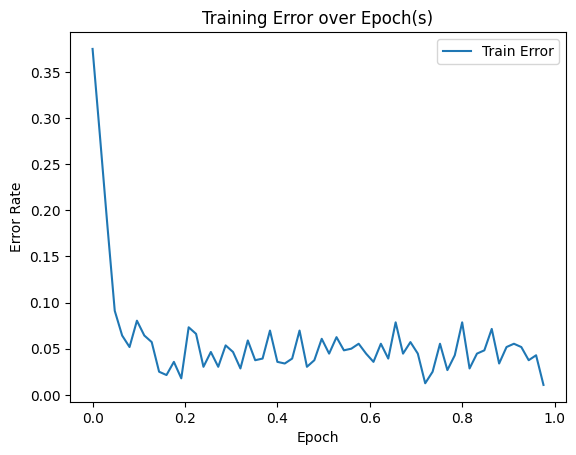

In [251]:
# Train Accuracy
if TRAIN: 
    train_epoch_line = [i/(len(train_dataset)/batch_size/ith) for i in range(len(error_train))]
    
    plt.plot(train_epoch_line, error_train, label='Train Error')
    plt.xlabel('Epoch')
    plt.ylabel('Error Rate')
    plt.title('Training Error over Epoch(s)')
    plt.legend()
    plt.show()

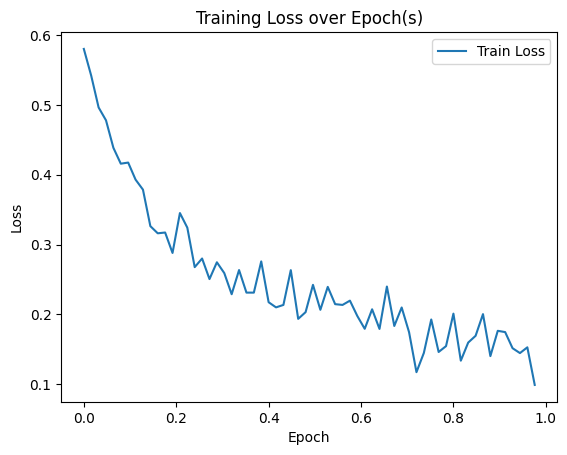

In [252]:
# Train Loss
if TRAIN: 
    plt.plot(train_epoch_line, loss_train, label='Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epoch(s)')
    plt.legend()
    plt.show()

In [253]:
# Train and Validation Error
if TRAIN :
    print(f'Error Validation: {error_validation}      Loss Validation: {loss_validation}')

Error Validation: [0.031714285714285716]      Loss Validation: [0.12927840942144395]


## Test Evaluation - Accuracy, Precision, Recall, F1, confusion matrices

In [254]:
# Generate Predictions on Test data
model.eval()  

predicted_labels = []

with torch.no_grad():
    for step, batch in enumerate(test_loader):
        input_ids, token_type_ids, attention_mask, labels,weight = [i.to(device) for i in batch]
        output = model(input_ids=input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)

        predicted_batch = torch.sigmoid(output.logits) 
        predicted_labels.append(predicted_batch.cpu().numpy())

predicted_labels = np.concatenate(predicted_labels, axis=0)
predicted_labels = (predicted_labels > 0.5).astype(int)

In [255]:
# remove good label
# test_labels = test_labels[:,:-1]
# predicted_labels = predicted_labels[:,:-1]

In [256]:
# Print Test evaluation
accuracy = accuracy_score(test_labels, predicted_labels)
w_accuracy = accuracy_score(test_labels, predicted_labels, sample_weight=test_weights)
any_accuracy = accuracy_score(np.concatenate(test_labels), np.concatenate(predicted_labels))
w_any_accuracy = accuracy_score(np.concatenate(test_labels), np.concatenate(predicted_labels), sample_weight=[i for i in test_weights for j in range(len(class_labels)-1)])
w_precision = precision_score(test_labels, predicted_labels, average='micro', sample_weight=test_weights)
precision = precision_score(test_labels, predicted_labels, average='micro')
w_recall = recall_score(test_labels, predicted_labels, average='micro', sample_weight=test_weights)
recall = recall_score(test_labels, predicted_labels, average='micro')
w_f1 = f1_score(test_labels, predicted_labels, average='micro', sample_weight=test_weights)
f1 = f1_score(test_labels, predicted_labels, average='micro')
confusion_matrices = multilabel_confusion_matrix(test_labels, predicted_labels)

print(f'Unweighted Accuracy (all {len(class_labels)} labels correct): {accuracy:.4f}')
print(f'Weighted Accuracy (all {len(class_labels)} labels correct): {w_accuracy:.4f}')
print(f'Unweighted Total Accuracy (total fraction of labels correct): {any_accuracy:.4f}')
print(f'Weighted Total Accuracy (total fraction of labels correct): {w_any_accuracy:.4f}')
print()
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print()
print(f'Weighted Precision: {w_precision:.4f}')
print(f'Weighted Recall: {w_recall:.4f}')
print(f'Weighted F1 Score: {w_f1:.4f}')
print()

print('    ---Confusion Matrices---\n\n[[true_negative, false_positive]\n [false_negative true_positive]]\n')
for label, confusion_matrix in zip(class_labels, confusion_matrices) :
    print(f'Confusion Matrix for {label}: \n{confusion_matrix}\n')

Unweighted Accuracy (all 7 labels correct): 0.9080
Weighted Accuracy (all 7 labels correct): 0.5699
Unweighted Total Accuracy (total fraction of labels correct): 0.9722
Weighted Total Accuracy (total fraction of labels correct): 0.8722

Precision: 0.7279
Recall: 0.4573
F1 Score: 0.5617

Weighted Precision: 0.8459
Weighted Recall: 0.4573
Weighted F1 Score: 0.5936

    ---Confusion Matrices---

[[true_negative, false_positive]
 [false_negative true_positive]]

Confusion Matrix for toxic: 
[[907   2]
 [ 58  33]]

Confusion Matrix for severe_toxic: 
[[994   0]
 [  6   0]]

Confusion Matrix for obscene: 
[[924  19]
 [ 20  37]]

Confusion Matrix for threat: 
[[997   0]
 [  3   0]]

Confusion Matrix for insult: 
[[922  19]
 [ 22  37]]

Confusion Matrix for identity_hate: 
[[982   0]
 [ 18   0]]



## Resources
- https://huggingface.co/docs/transformers/model_doc/bert#transformers.BertForSequenceClassification
- https://www.kaggle.com/code/samarthagaliprasad/bert-for-toxicity
- https://discuss.huggingface.co/t/class-weights-for-bertforsequenceclassification/1674/2
- https://discuss.pytorch.org/t/weighted-cross-entropy-for-each-sample-in-batch/101358/9
- https://github.com/AdeelH/pytorch-multi-class-focal-loss